In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [175]:
group_features_df = pd.read_pickle ('../scripts/tmp_group_features.pkl')
technique_features_df = pd.read_pickle ('../scripts/tmp_technique_features.pkl')
group_software_ID_vocab = pd.read_csv ('../data/interim/group_software_ID_vocab.csv', header= None)

technique_defenses_bypassed_vocab = pd.read_csv ('../data/interim/technique_defenses_bypassed_vocab.csv', header= None)
technique_data_sources_vocab  = pd.read_csv ('../data/interim/technique_data_sources_vocab.csv', header= None)
technique_detection_name_vocab  = pd.read_csv ('../data/interim/technique_detection_name_vocab.csv', header= None)
technique_mitigation_ID_vocab = pd.read_csv ('../data/interim/technique_mitigation_ID_vocab.csv', header= None)
technique_permissions_required_vocab = pd.read_csv ('../data/interim/technique_permissions_required_vocab.csv', header= None)
technique_platforms_vocab = pd.read_csv ('../data/interim/technique_platforms_vocab.csv', header= None)
technique_software_ID_vocab = pd.read_csv ('../data/interim/technique_software_ID_vocab.csv', header= None)

In [190]:
vocabs = [
group_software_ID_vocab,
technique_defenses_bypassed_vocab,
technique_data_sources_vocab,
technique_detection_name_vocab,
technique_mitigation_ID_vocab,
technique_permissions_required_vocab,
technique_platforms_vocab,
technique_software_ID_vocab,
]

In [191]:
for vocab in vocabs:
    print ('vocab_size:', len (vocab[0].tolist()))

vocab_size: 463
vocab_size: 24
vocab_size: 105
vocab_size: 105
vocab_size: 43
vocab_size: 5
vocab_size: 11
vocab_size: 635


In [176]:
group_features_df.head()

,group_ID,software_ID
0,G0099,[s0434]
1,G0006,"[s0017, s0025, s0119, s0026, s0121, s0002, s00..."
2,G0005,"[s0040, s0015, s0003]"
3,G0023,[s0064]
4,G0025,[s0069]


In [177]:
technique_features_df.head()

,technique_ID,platforms,tactics,data_sources,defenses_bypassed,permissions_required,mitigation_ID,detection_name,software_ID
0,T1548,"[linux, windows, macos]","[defense_evasion, privilege_escalation]","[command_command_execution, file_file_metadata...",[],"[administrator, user]","[m1047, m1038, m1028, m1026, m1022, m1052]","[command_execution, file_metadata, file_modifi...",[]
1,T1548.002,[windows],"[defense_evasion, privilege_escalation]","[command_command_execution, process_process_cr...",[windows_user_account_control],"[administrator, user]","[m1047, m1026, m1051, m1052]","[command_execution, process_creation, process_...","[s0584, s0129, s0640, s0606, s0570, s1068, s00..."
2,T1548.004,[macos],"[defense_evasion, privilege_escalation]","[process_os_api_execution, process_process_cre...",[],"[administrator, user]",[m1038],"[os_api_execution, process_creation]",[s0402]
3,T1548.001,"[linux, macos]","[defense_evasion, privilege_escalation]","[command_command_execution, file_file_metadata...",[],[user],[m1028],"[command_execution, file_metadata, file_modifi...","[s0401, s0276]"
4,T1548.003,"[linux, macos]","[defense_evasion, privilege_escalation]","[command_command_execution, file_file_modifica...",[],[user],"[m1028, m1026, m1022]","[command_execution, file_modification, process...","[s0154, s0281, s0279]"


# Maxium length of feature vector for each feature

In [178]:
def get_max_feature_length(df: pd.DataFrame(), id_name: str):
    for col in list (df.columns)[1:]:
        print ('{col}: {max_len}'.format(col = col, max_len = df[col].apply(lambda x: len(x)).max()))
        max_length_row_index = df[col].apply(len).idxmax()
        print ('ID with longest vector:', df.loc[max_length_row_index, id_name])


In [179]:
get_max_feature_length(group_features_df, 'group_ID')

software_ID: 46
ID with longest vector: G0016


In [180]:
get_max_feature_length(technique_features_df, 'technique_ID')

platforms: 10
ID with longest vector: T1110
tactics: 4
ID with longest vector: T1078
data_sources: 14
ID with longest vector: T1562
defenses_bypassed: 8
ID with longest vector: T1562
permissions_required: 4
ID with longest vector: T1485
mitigation_ID: 11
ID with longest vector: T1552
detection_name: 14
ID with longest vector: T1562
software_ID: 334
ID with longest vector: T1105


# Sparsity Matrix

In [181]:
import tensorflow as tf
from tensorflow import keras

In [182]:
def make_sparse_matrix (df, feature_name, vocab):
    data = df[feature_name]
    tf_data = tf.ragged.constant(data, dtype=tf.string)
    vectorize_layer = tf.keras.layers.TextVectorization (
        max_tokens = len(vocab) + 2,
        output_mode = 'multi_hot',
        # output_sequence_length = padded_len, 
        split= None,
        vocabulary = vocab,
        pad_to_max_tokens= True
    )
    one_hot =  vectorize_layer (tf_data)
    one_hot_array = one_hot.numpy()

    # Calculate the sparsity matrix (binary matrix with 1 for present values and 0 for absent values)
    sparsity_matrix = np.where(one_hot_array == 1, 1, 0)

    # Create a heatmap to visualize the sparsity matrix
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.imshow(sparsity_matrix, cmap='binary', aspect='auto', interpolation='nearest')
    plt.title('Sparsity Matrix for {feature_name}'.format(feature_name = feature_name))
    plt.xlabel('Feature Values')
    plt.ylabel('Examples')
    plt.show()

## Group Features

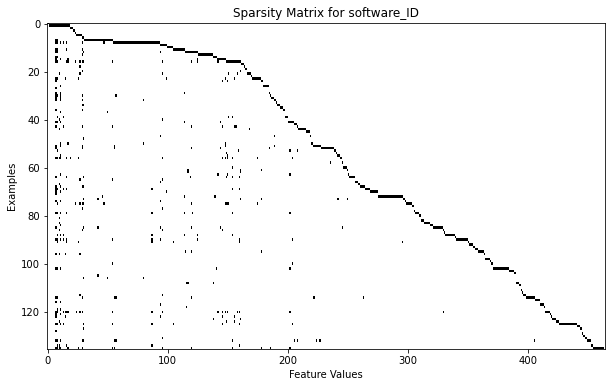

In [183]:
make_sparse_matrix(group_features_df, 'software_ID', group_software_ID_vocab[0].tolist())

## Technique Features

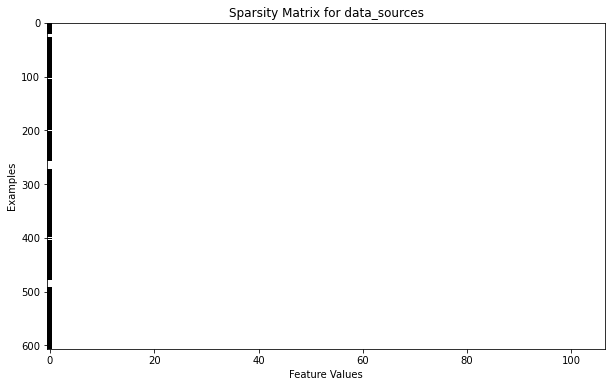

In [184]:
make_sparse_matrix (technique_features_df, 'data_sources', technique_data_sources_vocab [0].tolist())


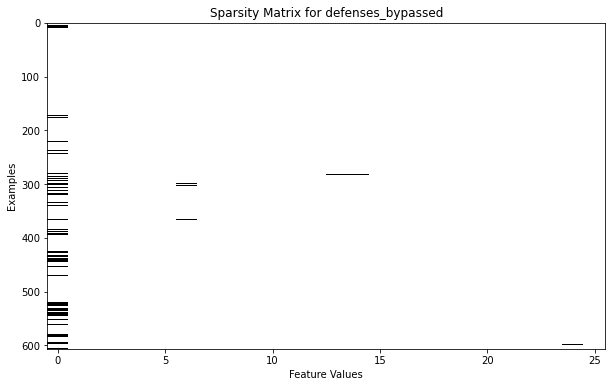

In [185]:
make_sparse_matrix (technique_features_df, 'defenses_bypassed', technique_defenses_bypassed_vocab [0].tolist())


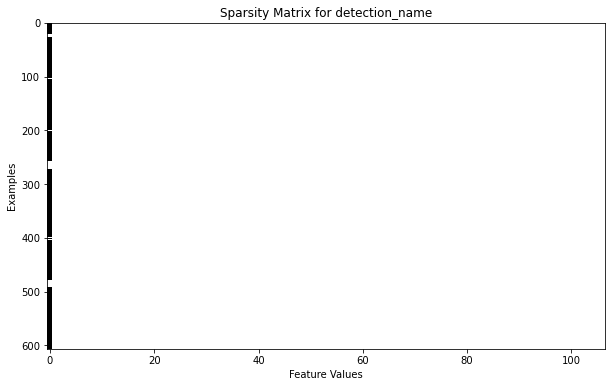

In [186]:
make_sparse_matrix (technique_features_df, 'detection_name', technique_detection_name_vocab [0].tolist())


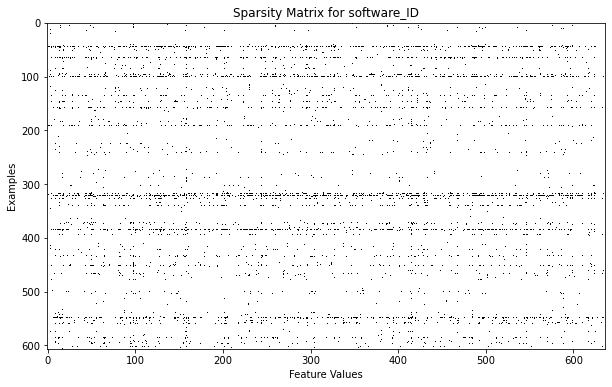

In [187]:
make_sparse_matrix (technique_features_df, 'software_ID', technique_software_ID_vocab [0].tolist())

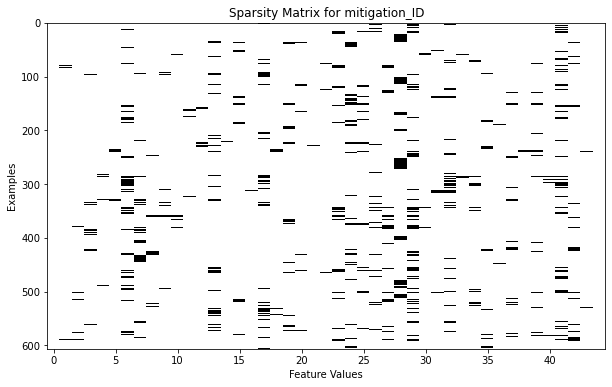

In [188]:
make_sparse_matrix (technique_features_df, 'mitigation_ID', technique_mitigation_ID_vocab [0].tolist())


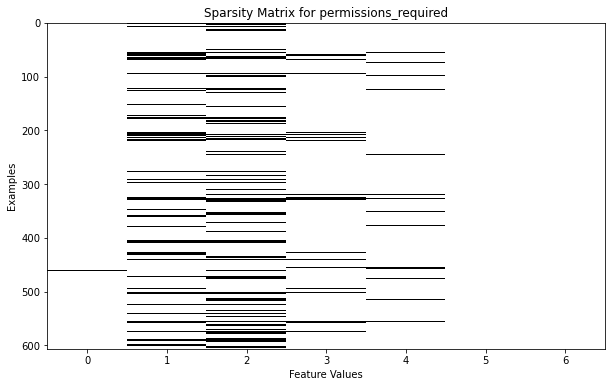

In [189]:
make_sparse_matrix (technique_features_df, 'permissions_required', technique_permissions_required_vocab [0].tolist())
